# Complexity++: N=3

Author(s): Kyle Godbey

Maintainer: Kyle Godbey

Our previous example was great for introducing us to the methods and computational framework, but it's time to take another step towards something a little trickier and expand our basis by one.

The key difference here is that now our ansatz will require another parameter, making it a 2d optimization problem. Our Hamiltonian will also change of course, meaning the bulk of the changes will be in those two cells since our VQE machinery can still handle it well. Even though most of this page will be the same as the last be sure to step through it all if only to see the nice two dimensional plot of the PES.

Let's set up imports again, it never gets old! We will again just use [pennylane](https://pennylane.ai/) and define the circuits and Hamiltonian directly in the form from [Cloud Quantum Computing of an Atomic Nucleus](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.210501).

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

plt.style.use(['science','notebook'])

Now we will define our 'device' (a simulator in this case) as well as our ansatz and Hamiltonian.

Here is where the first big change comes in, since we now need 3 qubits. Our ansatz circuit is thus a little more complicated than before, being a little deeper and requiring another variational parameter.

Our Hamiltonian is also changed, of course, but here we're still writing it out by hand, with automatic generation being introduced next.

  (-9.625) [Z2]
+ (-6.125) [Z1]
+ (0.21829) [Z0]
+ (15.531709) [I0]
+ (-3.91) [X1 X2]
+ (-3.91) [Y1 Y2]
+ (-2.1433) [X0 X1]
+ (-2.1433) [Y0 Y1]
(<Figure size 900x400 with 1 Axes>, <Axes:>)


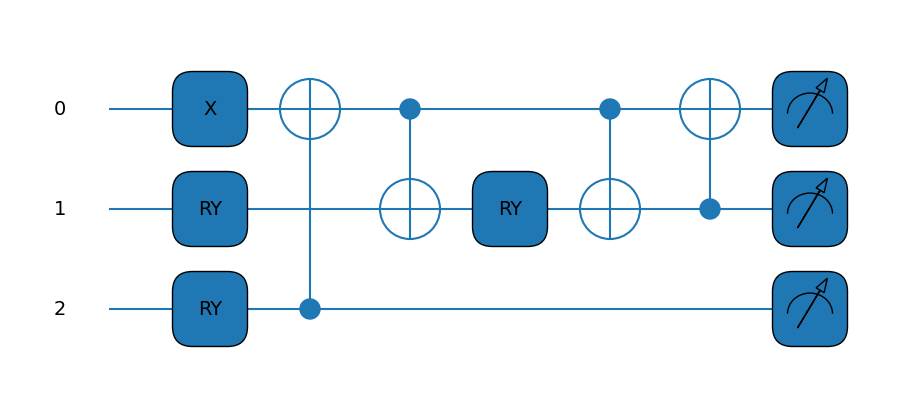

In [15]:
# In this case we now need 3 qubits

dev = qml.device("default.qubit", wires=3)

# Defining our ansatz circuit for the N=3 case

def circuit(params,wires):
    t0 = params[0]
    t1 = params[1]
    qml.PauliX(wires=0)
    qml.RY(t1, wires=1)
    qml.RY(t0, wires=2)
    qml.CNOT(wires=[2,0])
    qml.CNOT(wires=[0,1])
    qml.RY(-t1, wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,0])

# And building our Hamiltonian for the N=3 case

coeffs = [15.531709 ,-2.1433, -2.1433, 0.21829, -6.125, -9.625, -3.91, -3.91]
obs = [qml.Identity(0),qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1),qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliX(1) @ qml.PauliX(2),qml.PauliY(1) @ qml.PauliY(2)]

H = qml.Hamiltonian(coeffs, obs)
cost_fn = qml.ExpvalCost(circuit, H, dev)

# Let's print it out

print(H)

@qml.qnode(dev)
def draw_circuit(params):
    circuit(params,wires=dev.wires)
    return qml.expval(H)

qml.drawer.use_style('default')
print(qml.draw_mpl(draw_circuit)(init_params))

Amazing! That's an even better looking Hamiltonian! The circuit is starting to look a little more involved as well.

Now we'll set up what we'll need for the VQE procedure; namely some initial parameters and convergence info. You can select the initial guess randomly, but in this case we'll set it manually for repeatability.

In this case, we also need an additional parameter as mentioned when we set up our circuit.

In [16]:
# Our parameter array, now our params have a friend :3

init_params = np.array([2.5,4.5])

# Convergence information and step size

max_iterations = 500
conv_tol = 1e-06
step_size = 0.01

Finally, the VQE block. We're still using the standard gradient descent optimizer since it worked so well before, but soon the time will come to shop around for better options.

In [17]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 22.73185830 MeV,  Convergence parameter = 0.16533643 MeV
Iteration = 20,  Energy = 13.86733622 MeV,  Convergence parameter = 0.85950160 MeV
Iteration = 40,  Energy = 0.66226895 MeV,  Convergence parameter = 0.41277410 MeV
Iteration = 60,  Energy = -1.94958676 MeV,  Convergence parameter = 0.01827050 MeV
Iteration = 80,  Energy = -2.04226133 MeV,  Convergence parameter = 0.00054725 MeV
Iteration = 100,  Energy = -2.04502496 MeV,  Convergence parameter = 0.00001629 MeV

Final value of the energy = -2.04510468 MeV
Number of iterations =  116


As expected, we get closer to the true value with our expanded basis, though we're not all the way there. We still match our reference value very well, meaning we're on the right track for building out our robust nuclear VQE framework, so good job team!

Let's plot the convergence next and see if going to 2-D hurt us any.

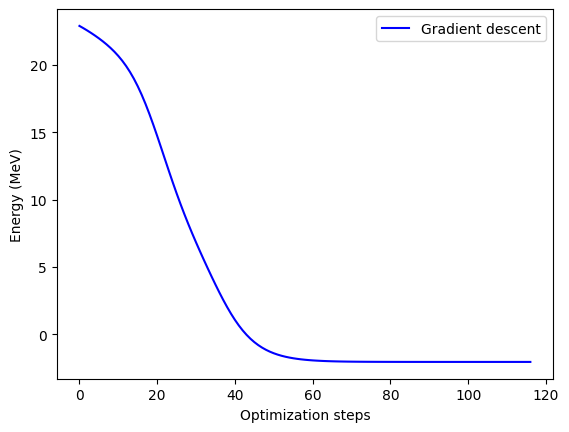

In [18]:
plt.plot(gd_cost_history, "b", label="Gradient descent")

plt.ylabel("Energy (MeV)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Finally, we can plot how we trace the potential energy surface (PES) as we find a solution. Now that we've moved up a dimension, we'll be plotting an actual surface instead of a line, so be sure to take note of the features of the surface in parameter space.

If you're running this yourself, you can either generate the surface yourself or put this code in a cell to download it locally:

`!wget https://github.com/kylegodbey/nuclear-quantum-computing/raw/main/nuclear-qc/vqe/deut_pes_n2.npy`

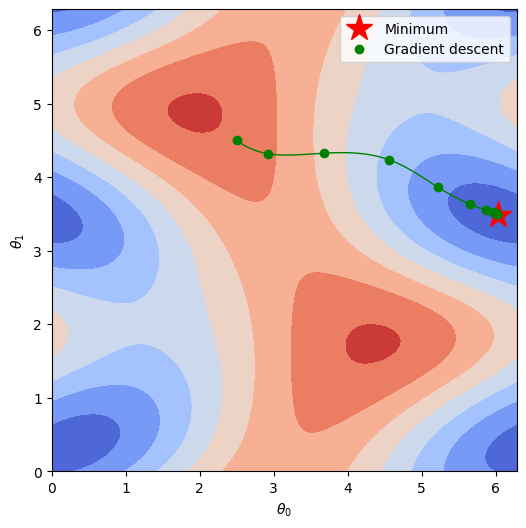

In [20]:
# Discretize the parameter space
theta0 = np.linspace(0.0, 2.0 * np.pi, 100)
theta1 = np.linspace(0.0, 2.0 * np.pi, 100)

# Load energy value at each point in parameter space
pes = np.load("deut_pes_n3.npy")

# Get the minimum of the PES
minloc=np.unravel_index(pes.argmin(),pes.shape)

# Plot energy landscape
fig, axes = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta0, theta1, pes.T, cmap=cmap)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")

plt.plot(theta0[minloc[0]],theta1[minloc[1]],"r*",markersize=20,label="Minimum")

# Plot optimization path for gradient descent. Plot every 10th point.
gd_color = "g"

plt.plot(
    np.array(gd_param_history)[::10, 0],
    np.array(gd_param_history)[::10, 1],
    ".",markersize=12,
    color=gd_color,
    linewidth=2,
    label="Gradient descent",
)
plt.plot(
    np.array(gd_param_history)[:, 0],
    np.array(gd_param_history)[:, 1],
    "-",
    color=gd_color,
    linewidth=1,
)


plt.legend()
plt.show()

This is all looking very nice, so now let's take it to the extreme! Next up we're going to programmatically generate our Hamiltonian and ansatz to an arbitrary, user-defined order. This means we'll probably take a big performance hit, but shooting for scalability is always a worthy endeavor.